<a href="https://colab.research.google.com/github/Fran-Sierra/Data-analysis-in-Football/blob/main/colab_files/xThreat(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install socceraction

  Using cached numpy-1.26.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [ ]:
pip install numpy==1.24.4 # restart session

  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
socceraction 1.5.0 requires numpy<2.0.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [ ]:
pip install scipy

In [ ]:
pip install mplsoccer

In [ ]:
!pip install matplotsoccer

In [ ]:
from google.colab import auth
import pandas as pd

# Will collect your credentials
auth.authenticate_user()

In [ ]:
import pandas as pd
import matplotsoccer as mps
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline

import socceraction.xthreat as xthreat
import socceraction.spadl as spadl

In [ ]:
%run '/content/drive/MyDrive/Colab Notebooks/Plot_attack_&_Pass_nodes V.2.ipynb'

#Match Momentum
it needs two arguments, team id and country, but takes 'england' a country by default

In [ ]:
def match_momentum(team_id,country='england'):

  black_list=[]
  xT={'created':[],
      'received':[],
      'match':[]
  }
  matches=matches_country(country)
  events_team=team_events(country,team_id)
  team_matches=matches[(matches.home_team==team_id)|(matches.away_team==team_id)]
  succesful_home_events=pd.DataFrame()
  succesful_away_events=pd.DataFrame()
  # calculating the grid for each match of teamid
  for i, row in team_matches.iterrows():
    match_id=row['matchId']
    print(match_id)

    # home team = team _id
    if row['home_team']==team_id:



      #                                                    for home_team (team to analyze)

      teamid=row['home_team']
      home_events=events_team
      match_home_events=home_events[home_events.matchId==match_id]
      last_1H_minute=match_home_events[(match_home_events.matchPeriod=='1H')]['eventSec'].max()

      # Goals

      # home_events.tag_100==101

      # relevant subevents for match momentum
      mt_match_home_events=match_home_events [(match_home_events['subEventName'].isin( ['Ground loose ball duel', 'Throw in', 'Air duel', 'Head pass','Ground attacking duel', 'Simple pass', 'Smart pass', 'Touch','Cross', 'High pass','Acceleration'] )) ]

      # filtering by succesful events
      succesful_home_events=mt_match_home_events[mt_match_home_events.tag_1800==1801]

      # dropping useless columns
      succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',
       'tag_800', 'tag_900', 'tag_1000', 'tag_1100', 'tag_1200', 'tag_1300',
       'tag_1400', 'tag_1600', 'tag_1700','tag_1900', 'tag_2000',
       'tag_2100','weight', 'height'], inplace=True)

      # adding last 1H minute to 2H events
      succesful_home_events.loc[succesful_home_events.matchPeriod=='2H','eventSec']=succesful_home_events[succesful_home_events.matchPeriod=='2H']['eventSec']+last_1H_minute

      #converting seconds to minutes
      succesful_home_events.loc[:,'eventSec']=round(succesful_home_events['eventSec']/60)

      ################################################                                   FEED BOTH GRIDS WITH THE EVENTS FOR BOTH TEAMS IN THE MATCH

    #   #                                                           GRID HOME
      try:
        home_xTModel = xthreat.ExpectedThreat(l=12, w=8)
        df_actions_home_team=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/actions_{match_id}.csv')
        home_xTModel.fit(df_actions_home_team)
        home_xTModel.save_model(f'{teamid}_{match_id}.json',overwrite=True)


        # xT for each event momentum
        df_home_grid=pd.read_json(f'{teamid}_{match_id}.json')
        df_home_grid=np.array(df_home_grid)
        grid_rows, grid_cols=df_home_grid.shape

        df_xT_home=succesful_home_events
        df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
        df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
        df_xT_home['x2_bin']=pd.cut(df_xT_home['position2_x'], bins=grid_cols, labels=False)
        df_xT_home['y2_bin']=pd.cut(df_xT_home['position2_y'], bins=grid_rows, labels=False)

        df_xT_home['x1_bin']=df_xT_home['x1_bin'].astype(int)
        df_xT_home['y1_bin']=df_xT_home['y1_bin'].astype(int)
        df_xT_home['x2_bin']=df_xT_home['x2_bin'].astype(int)
        df_xT_home['y2_bin']=df_xT_home['y2_bin'].astype(int)

        df_xT_home['start_zone_value']=df_xT_home[['x1_bin','y1_bin']].apply(lambda x: df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_home['end_zone_value']=df_xT_home[['x2_bin','y2_bin']].apply(lambda x:df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_home['xT']=df_xT_home['end_zone_value']-df_xT_home['start_zone_value']
        # df.add(df_grid)
        # interp = xTModel.interpolator()
        # x = np.linspace(0, 105, 1050)
        # y = np.linspace(0, 68, 680)
        # mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")



      except:
        print(f'match {match_id} not fitted')
        black_list.append(match_id)
        continue


      #                                             for away team

      teamid=row['away_team']
      away_events=team_events(country,teamid)
      match_away_events=away_events[away_events.matchId==match_id]
      last_1H_minute=match_away_events[(match_away_events.matchPeriod=='1H')]['eventSec'].max()

      # relevant subevents for match momentum
      mt_match_away_events=match_away_events [(match_away_events['subEventName'].isin( ['Ground loose ball duel', 'Throw in', 'Air duel', 'Head pass','Ground attacking duel', 'Simple pass', 'Smart pass', 'Touch','Cross', 'High pass','Acceleration'] )) ]

      # filtering by succesful events
      succesful_away_events=mt_match_away_events[mt_match_away_events.tag_1800==1801]


      # dropping useless columns
      succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',
       'tag_800', 'tag_900', 'tag_1000', 'tag_1100', 'tag_1200', 'tag_1300',
       'tag_1400', 'tag_1600', 'tag_1700','tag_1900', 'tag_2000',
       'tag_2100','weight', 'height'], inplace=True)


      # adding last 1H minute to 2H events
      succesful_away_events.loc[succesful_away_events.matchPeriod=='2H','eventSec']=succesful_away_events[succesful_away_events.matchPeriod=='2H']['eventSec']+last_1H_minute


      #converting seconds to minutes
      succesful_away_events.loc[:,'eventSec']=round(succesful_away_events['eventSec']/60)


    #   #                                                           GRID AWAY
      try:
        away_xTModel = xthreat.ExpectedThreat(l=12, w=8)
        df_actions_away_team=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/actions_{match_id}.csv')
        away_xTModel.fit(df_actions_away_team)
        away_xTModel.save_model(f'{teamid}_{match_id}.json',overwrite=True)


        # xT for each event momentum
        df_away_grid=pd.read_json(f'{teamid}_{match_id}.json')
        df_away_grid=df_away_grid.iloc[:,::-1]
        df_away_grid=np.array(df_away_grid)
        grid_rows, grid_cols=df_away_grid.shape

        df_xT_away=succesful_away_events
        df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
        df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
        df_xT_away['x2_bin']=pd.cut(df_xT_away['position2_x'], bins=grid_cols, labels=False)
        df_xT_away['y2_bin']=pd.cut(df_xT_away['position2_y'], bins=grid_rows, labels=False)

        df_xT_away['x1_bin']=df_xT_away['x1_bin'].astype(int)
        df_xT_away['y1_bin']=df_xT_away['y1_bin'].astype(int)
        df_xT_away['x2_bin']=df_xT_away['x2_bin'].astype(int)
        df_xT_away['y2_bin']=df_xT_away['y2_bin'].astype(int)

        df_xT_away['start_zone_value']=df_xT_away[['x1_bin','y1_bin']].apply(lambda x: df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_away['end_zone_value']=df_xT_away[['x2_bin','y2_bin']].apply(lambda x:df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_away['xT']=df_xT_away['end_zone_value']-df_xT_away['start_zone_value']

      except:
        print(f'match {match_id} not fitted')
        black_list.append(match_id)
        continue
       #                                                CONCATENATE DATAFRAMES


      df_xT_home.loc[df_xT_home.position2_x<50, 'xT']=0
      df_home=df_xT_home.groupby(by='eventSec').agg({'teamId':['mean'],'position1_x':['mean'],'position1_y':['mean'],'position2_x':['mean'],'position2_y':['mean'],'xT':['mean','sum']})
      df_home.fillna(0,inplace=True)
      # df_home['agg_xT']=df_home['xT'].rolling(5).sum()



      df_xT_away.loc[df_xT_away.position2_x<50, 'xT']=0
      df_away=df_xT_away.groupby(by='eventSec').agg({'teamId':['mean'],'position1_x':['mean'],'position1_y':['mean'],'position2_x':['mean'],'position2_y':['mean'],'xT':['mean','sum']})
      df_away.fillna(0,inplace=True)

      df=df_home.merge(df_away,left_index=True,right_index=True, how='outer',suffixes=['_home','_away'])[['teamId_home','teamId_away','xT_home','xT_away']]
      df['teamId_home']=row['home_team']
      df['teamId_away']=row['away_team']
      df.fillna(0,inplace=True)
      df['home_agg_xT']=df[('xT_home','sum')].rolling(5).sum()
      df['away_agg_xT']=df[('xT_away','sum')].rolling(5).sum()
      df['diff_xT']=df['home_agg_xT']-df['away_agg_xT']
      df.fillna(0, inplace=True)
      xT['created']=df[('xT_home','sum')].sum()
      xT['received']=df[('xT_away','sum')].sum()
      xT['match']=match_id


      fig, ax = plt.subplots()

      x=df.index
      y=df.diff_xT
      color_local='red'
      color_away='lightblue'
      X_Y_Spline=make_interp_spline(x,y)
      X_=np.linspace(x.min(),x.max(),500)
      Y_=X_Y_Spline(X_)
      plt.plot(X_ ,Y_)

      home_team=row['home_name']
      away_team=row['away_name']
      ax.set_title(f'{match_id} Home')
      plt.axhline(0)
      plt.fill_between(X_,Y_, color=color_local,where=Y_ >0, label=f'{home_team}')

      plt.fill_between(X_,Y_, color=color_away,where=Y_ <0,label=f'{away_team}')

      plt.legend()

      plt.show()
      print(f'match id: {match_id}')






    else:
      print('----------------------------------ELSE')
            #                                             for away team (Team to analyze)

      teamid=row['away_team']
      away_events=events_team
      match_away_events=away_events[away_events.matchId==match_id]
      last_1H_minute=match_away_events[(match_away_events.matchPeriod=='1H')]['eventSec'].max()

      # relevant subevents for match momentum
      mt_match_away_events=match_away_events [(match_away_events['subEventName'].isin( ['Ground loose ball duel', 'Throw in', 'Air duel', 'Head pass','Ground attacking duel', 'Simple pass', 'Smart pass', 'Touch','Cross', 'High pass','Acceleration'] )) ]

      # filtering by succesful events
      succesful_away_events=mt_match_away_events[mt_match_away_events.tag_1800==1801]


      # dropping useless columns
      succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',
       'tag_800', 'tag_900', 'tag_1000', 'tag_1100', 'tag_1200', 'tag_1300',
       'tag_1400', 'tag_1600', 'tag_1700','tag_1900', 'tag_2000',
       'tag_2100','weight', 'height'], inplace=True)


      # adding last 1H minute to 2H events
      succesful_away_events.loc[succesful_away_events.matchPeriod=='2H','eventSec']=succesful_away_events[succesful_away_events.matchPeriod=='2H']['eventSec']+last_1H_minute


      #converting seconds to minutes
      succesful_away_events.loc[:,'eventSec']=round(succesful_away_events['eventSec']/60)


    #   #                                                           GRID AWAY
      try:
        print('-------------------------------------TRY:AWAY')
        away_xTModel = xthreat.ExpectedThreat(l=12, w=8)
        df_actions_away_team=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/actions_{match_id}.csv')
        away_xTModel.fit(df_actions_away_team)
        away_xTModel.save_model(f'{teamid}_{match_id}.json',overwrite=True)


        # xT for each event momentum
        df_away_grid=pd.read_json(f'{teamid}_{match_id}.json')
        df_away_grid=df_away_grid.iloc[:,::-1]
        df_away_grid=np.array(df_away_grid)
        grid_rows, grid_cols=df_away_grid.shape

        df_xT_away=succesful_away_events
        df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
        df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
        df_xT_away['x2_bin']=pd.cut(df_xT_away['position2_x'], bins=grid_cols, labels=False)
        df_xT_away['y2_bin']=pd.cut(df_xT_away['position2_y'], bins=grid_rows, labels=False)

        df_xT_away['x1_bin']=df_xT_away['x1_bin'].astype(int)
        df_xT_away['y1_bin']=df_xT_away['y1_bin'].astype(int)
        df_xT_away['x2_bin']=df_xT_away['x2_bin'].astype(int)
        df_xT_away['y2_bin']=df_xT_away['y2_bin'].astype(int)

        df_xT_away['start_zone_value']=df_xT_away[['x1_bin','y1_bin']].apply(lambda x: df_away_grid[x[1]][x[0]] , axis=1)
        df_xT_away['end_zone_value']=df_xT_away[['x2_bin','y2_bin']].apply(lambda x:df_away_grid[x[1]][x[0]] , axis=1)
        df_xT_away['xT']=df_xT_away['end_zone_value']-df_xT_away['start_zone_value']

      except:
        print(f'match {match_id} not fitted')
        black_list.append(match_id)
        continue

            #                                                    for home_team

      print('------------------------------------------------TRY:HOME')
      teamid=row['home_team']
      home_events=team_events(country,teamid)
      match_home_events=home_events[home_events.matchId==match_id]
      last_1H_minute=match_home_events[(match_home_events.matchPeriod=='1H')]['eventSec'].max()

      # relevant subevents for match momentum
      mt_match_home_events=match_home_events [(match_home_events['subEventName'].isin( ['Ground loose ball duel', 'Throw in', 'Air duel', 'Head pass','Ground attacking duel', 'Simple pass', 'Smart pass', 'Touch','Cross', 'High pass','Acceleration'] )) ]

      # filtering by succesful events
      succesful_home_events=mt_match_home_events[mt_match_home_events.tag_1800==1801]

      # dropping useless columns
      succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',
       'tag_800', 'tag_900', 'tag_1000', 'tag_1100', 'tag_1200', 'tag_1300',
       'tag_1400', 'tag_1600', 'tag_1700','tag_1900', 'tag_2000',
       'tag_2100','weight', 'height'], inplace=True)

      # adding last 1H minute to 2H events
      succesful_home_events.loc[succesful_home_events.matchPeriod=='2H','eventSec']=succesful_home_events[succesful_home_events.matchPeriod=='2H']['eventSec']+last_1H_minute

      #converting seconds to minutes
      succesful_home_events.loc[:,'eventSec']=round(succesful_home_events['eventSec']/60)



    #   #                                                           GRID HOME
      try:
        home_xTModel = xthreat.ExpectedThreat(l=12, w=8)
        df_actions_home_team=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/actions_{match_id}.csv')
        home_xTModel.fit(df_actions_home_team)
        home_xTModel.save_model(f'{teamid}_{match_id}.json',overwrite=True)


        # xT for each event momentum
        df_home_grid=pd.read_json(f'{teamid}_{match_id}.json')
        df_home_grid=np.array(df_home_grid)
        grid_rows, grid_cols=df_home_grid.shape

        df_xT_home=succesful_home_events
        df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
        df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
        df_xT_home['x2_bin']=pd.cut(df_xT_home['position2_x'], bins=grid_cols, labels=False)
        df_xT_home['y2_bin']=pd.cut(df_xT_home['position2_y'], bins=grid_rows, labels=False)

        df_xT_home['x1_bin']=df_xT_home['x1_bin'].astype(int)
        df_xT_home['y1_bin']=df_xT_home['y1_bin'].astype(int)
        df_xT_home['x2_bin']=df_xT_home['x2_bin'].astype(int)
        df_xT_home['y2_bin']=df_xT_home['y2_bin'].astype(int)

        df_xT_home['start_zone_value']=df_xT_home[['x1_bin','y1_bin']].apply(lambda x: df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_home['end_zone_value']=df_xT_home[['x2_bin','y2_bin']].apply(lambda x:df_home_grid[x[1]][x[0]] , axis=1)
        df_xT_home['xT']=df_xT_home['end_zone_value']-df_xT_home['start_zone_value']
        # df.add(df_grid)
        # interp = xTModel.interpolator()
        # x = np.linspace(0, 105, 1050)
        # y = np.linspace(0, 68, 680)
        # mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")



      except:
        print(f'match {match_id} not fitted')
        black_list.append(match_id)
        continue

             #                                                CONCATENATE DATAFRAMES


      df_xT_home.loc[df_xT_home.position2_x<50, 'xT']=0
      df_home=df_xT_home.groupby(by='eventSec').agg({'teamId':['mean'],'position1_x':['mean'],'position1_y':['mean'],'position2_x':['mean'],'position2_y':['mean'],'xT':['mean','sum']})
      df_home.fillna(0,inplace=True)
      # df_home['agg_xT']=df_home['xT'].rolling(5).sum()



      df_xT_away.loc[df_xT_away.position2_x<50, 'xT']=0
      df_away=df_xT_away.groupby(by='eventSec').agg({'teamId':['mean'],'position1_x':['mean'],'position1_y':['mean'],'position2_x':['mean'],'position2_y':['mean'],'xT':['mean','sum']})
      df_away.fillna(0,inplace=True)

      df=df_home.merge(df_away,left_index=True,right_index=True, how='outer',suffixes=['_home','_away'])[['teamId_home','teamId_away','xT_home','xT_away']]
      df['teamId_home']=row['home_team']
      df['teamId_away']=row['away_team']
      df.fillna(0,inplace=True)
      df['home_agg_xT']=df[('xT_home','sum')].rolling(5).sum()
      df['away_agg_xT']=df[('xT_away','sum')].rolling(5).sum()
      df['diff_xT']=df['away_agg_xT']-df['home_agg_xT']
      df.fillna(0, inplace=True)

      xT['received']=df[('xT_home','sum')].sum()
      xT['created']=df[('xT_away','sum')].sum()
      xT['match']=match_id



      fig, ax = plt.subplots()

      x=df.index
      y=df.diff_xT
      color_away='red'
      color_home='lightblue'
      X_Y_Spline=make_interp_spline(x,y)
      X_=np.linspace(x.min(),x.max(),500)
      Y_=X_Y_Spline(X_)
      plt.plot(X_ ,Y_)

      home_team=row['home_name']
      away_team=row['away_name']
      ax.set_title(f'{match_id} Away')
      plt.axhline(0)
      plt.fill_between(X_,Y_, color=color_away,where=Y_ >0, label=f'{away_team}')

      plt.fill_between(X_,Y_, color=color_home,where=Y_ <0,label=f'{home_team}')
      plt.legend()

      plt.show()

    # break














  return df_xT_home








<ipython-input-6-d4871947b631>:13: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_matches = pd.read_gbq(query_cntry, project_id)
<ipython-input-6-87c72469d020>:17: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_events = pd.read_gbq(query_cntry, project_id)


2499725


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  32


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  32


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

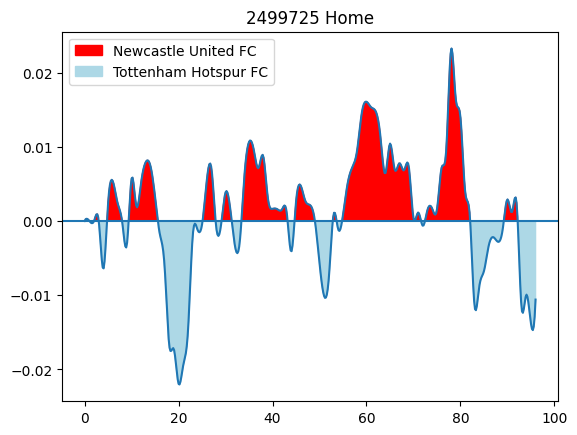

match id: 2499725
2499731
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  21
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  21


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

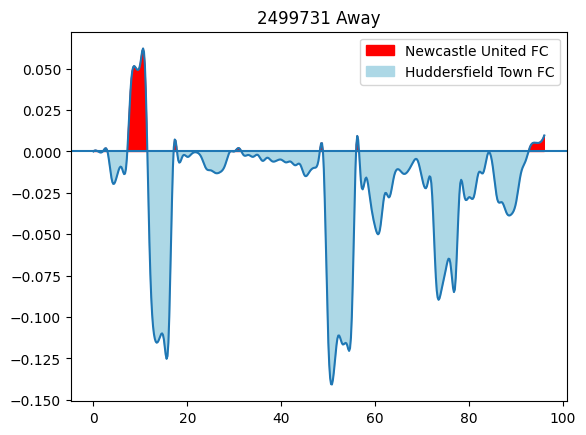

2499745


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  26


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  26


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

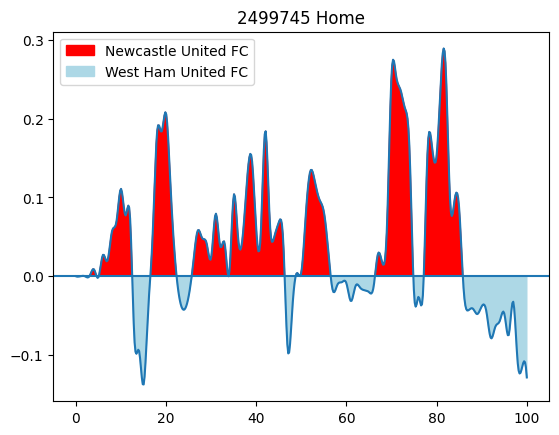

match id: 2499745
2499757
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  16
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  16


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

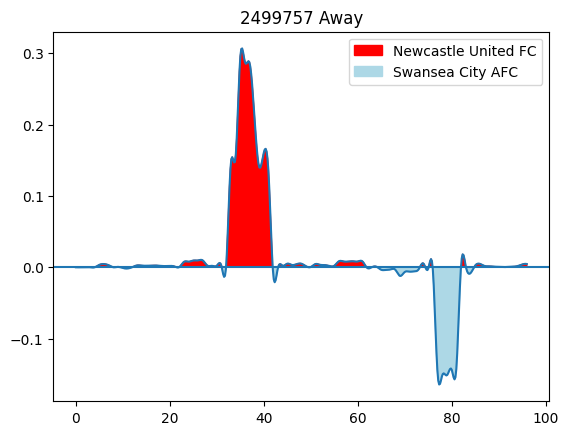

2499765


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  22


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  22


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

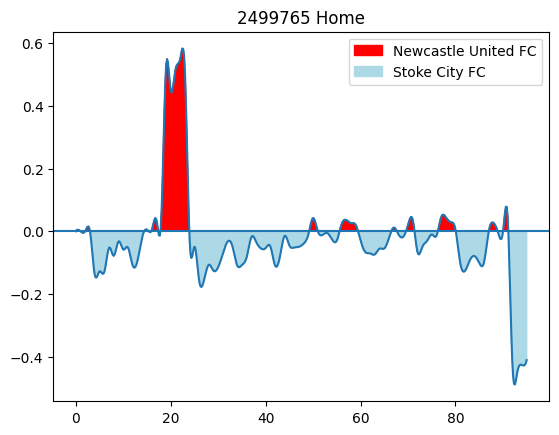

match id: 2499765
2499770
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  24
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  24


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

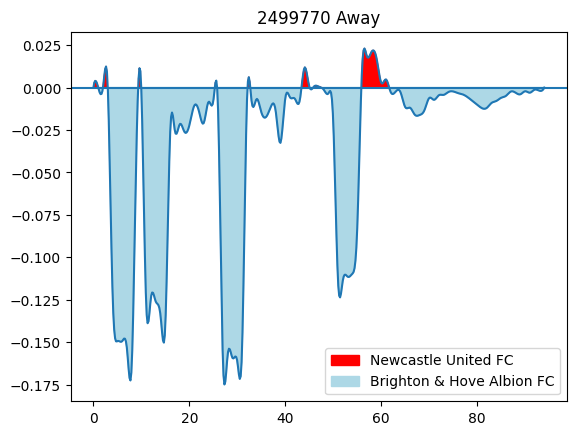

2499785


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  29


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  29


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

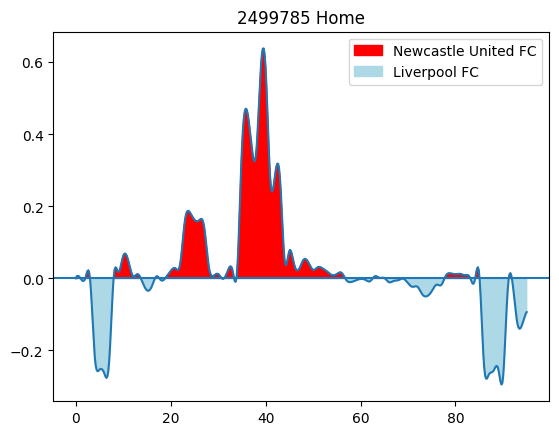

match id: 2499785
2499795
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  33
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  33


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

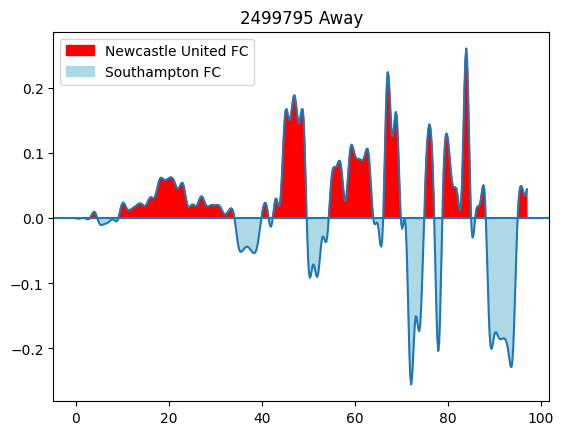

2499803


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  22


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  22


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

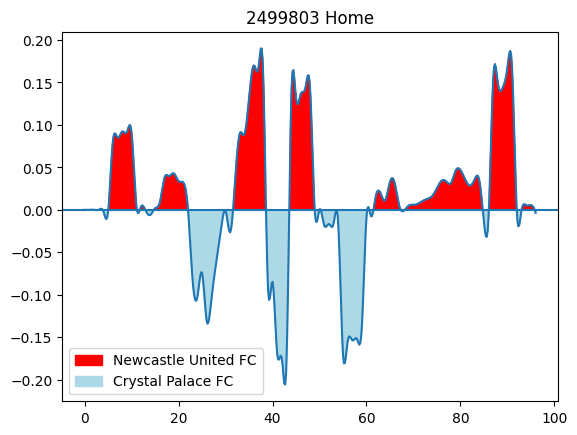

match id: 2499803
2499812
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  25
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  25


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

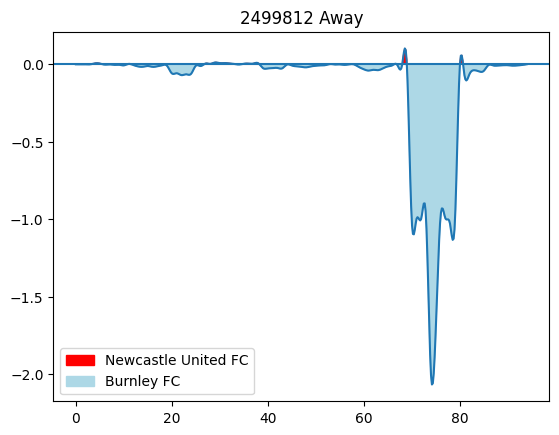

2499823


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  22


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  22


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

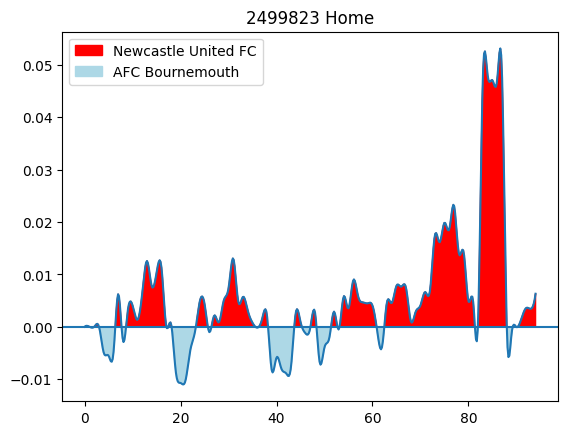

match id: 2499823
2499836
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  37
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  37


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

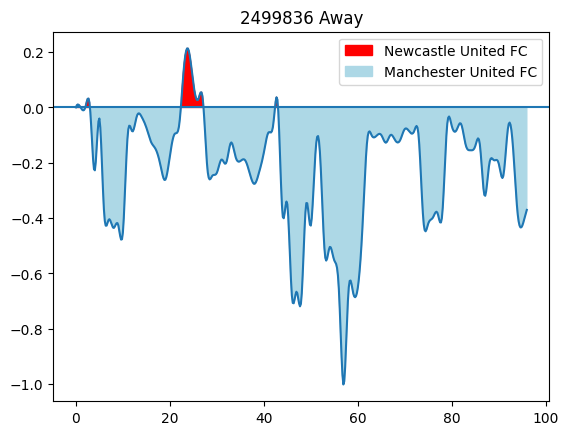

2499844


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  25


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  25


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

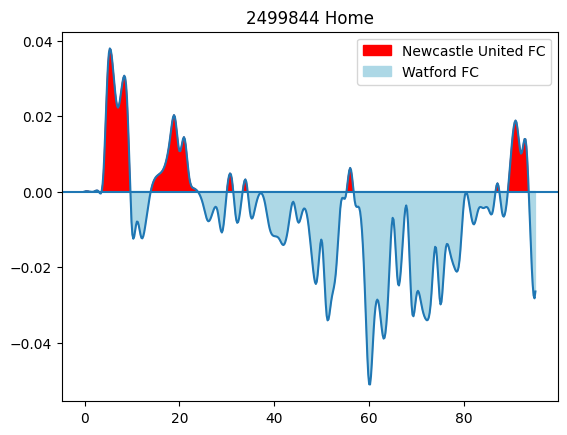

match id: 2499844
2499854
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  31
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  31


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

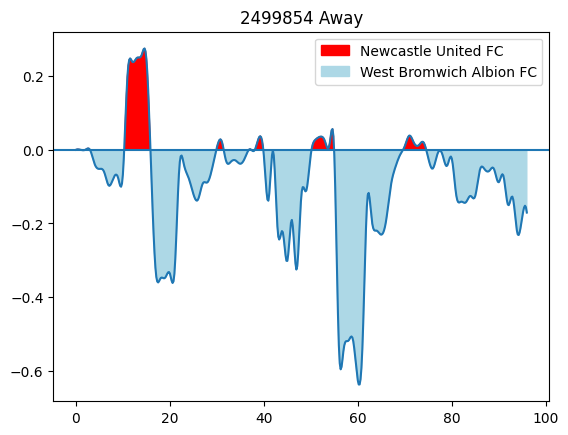

2499862
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  35
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  35


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

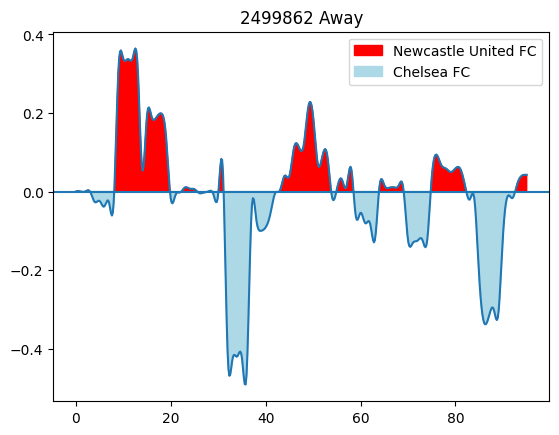

2499874


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  32


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  32


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

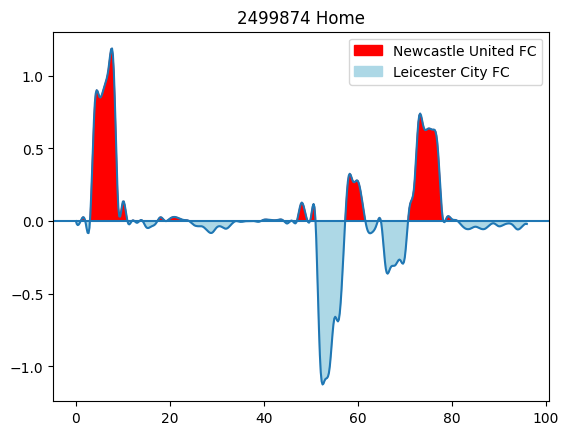

match id: 2499874
2499885


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  21


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  21


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

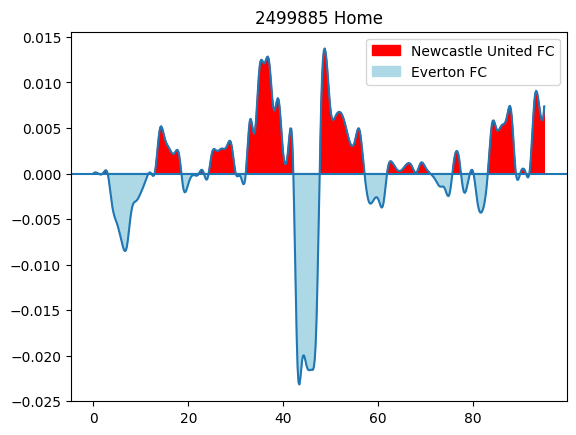

match id: 2499885
2499890
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  30
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  30


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

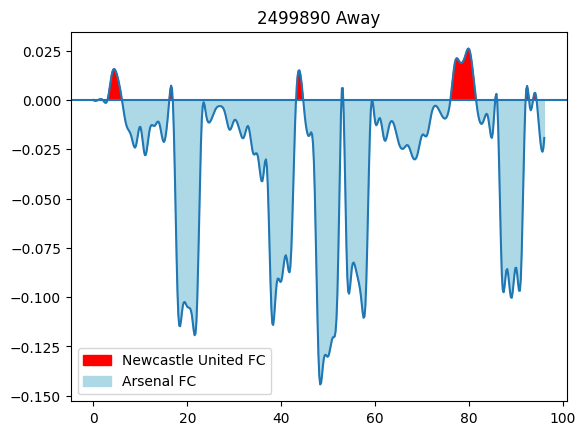

2499908
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  24
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  24


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

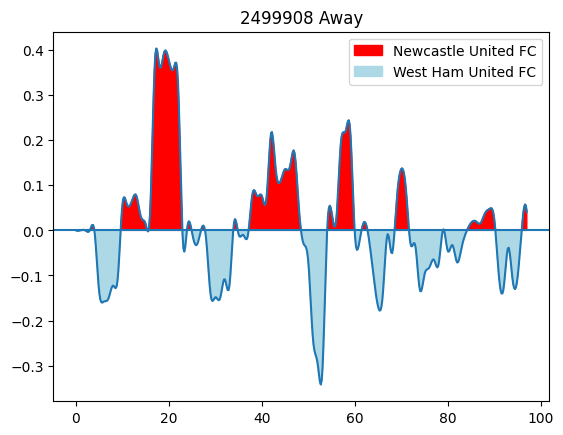

2499915


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  35


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  35


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

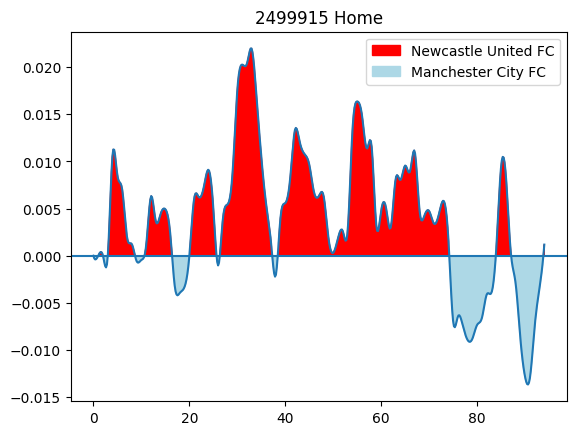

match id: 2499915
2499925
# iterations:  1
match 2499925 not fitted
2499936
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',
<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  20
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  20


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

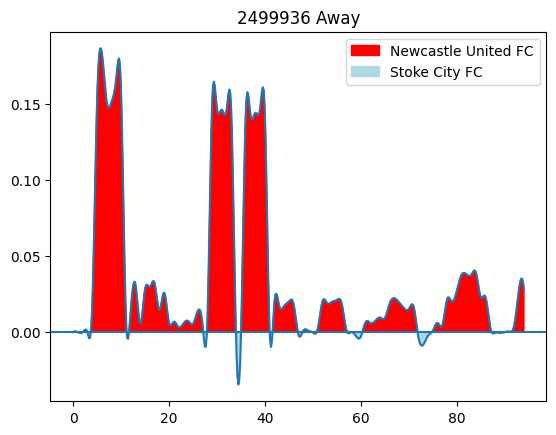

2499945


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  30


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  30


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

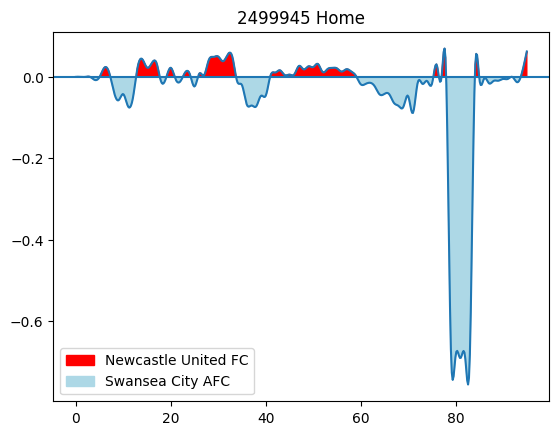

match id: 2499945
2499954
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  37
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  37


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

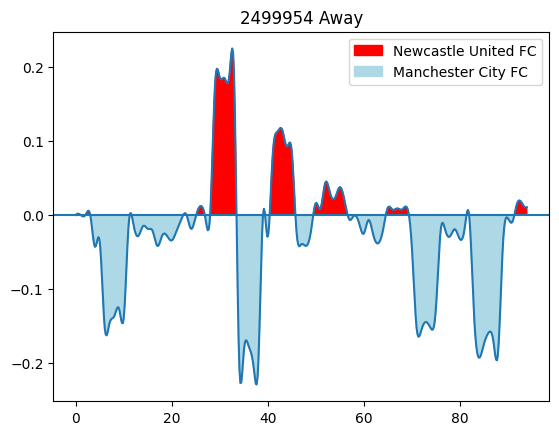

2499964


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  18


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  18


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

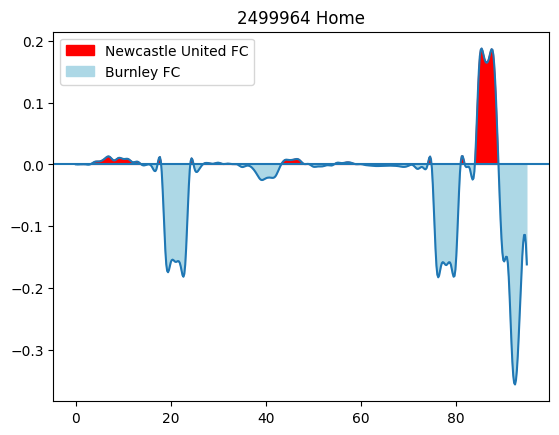

match id: 2499964
2499973
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  21
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  21


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

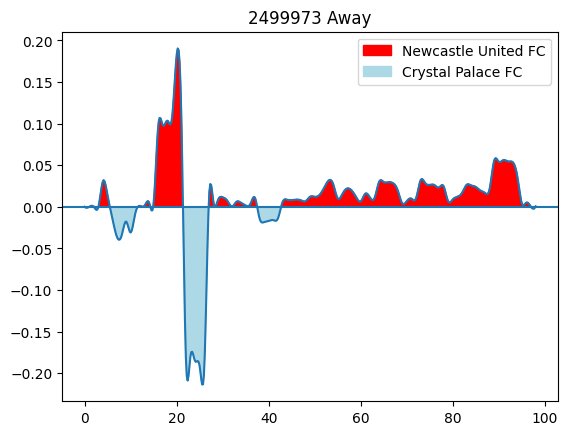

2499983


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  22


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  22


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

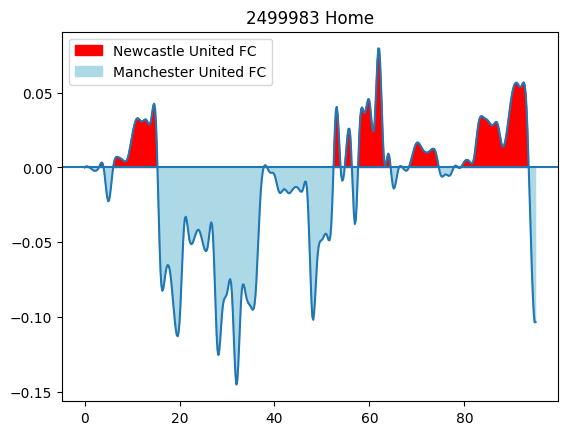

match id: 2499983
2499989
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  31
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  31


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

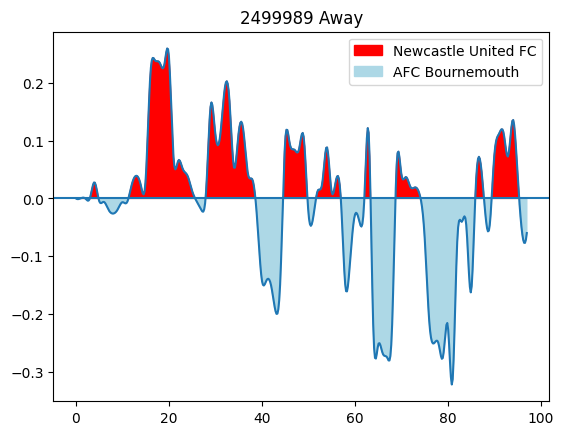

2500003
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  32
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  32


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

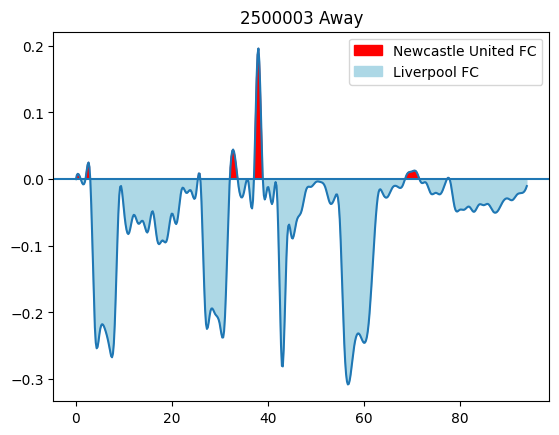

2500015


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  25


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  25


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

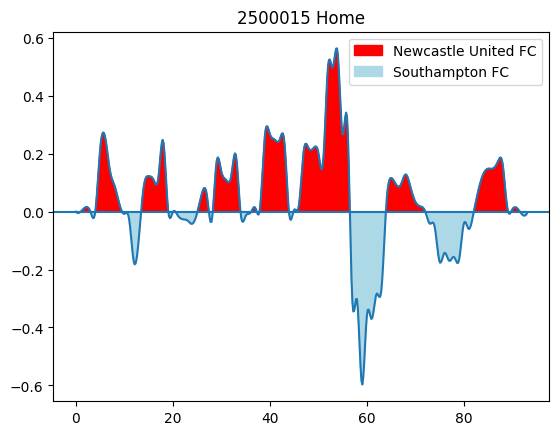

match id: 2500015
2500035


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  27


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  27


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

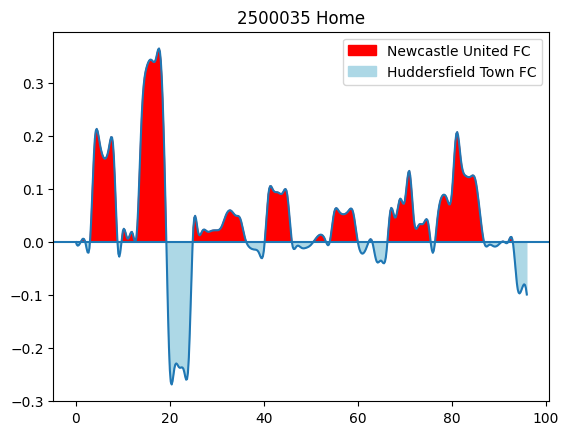

match id: 2500035
2500044
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  28
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  28


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

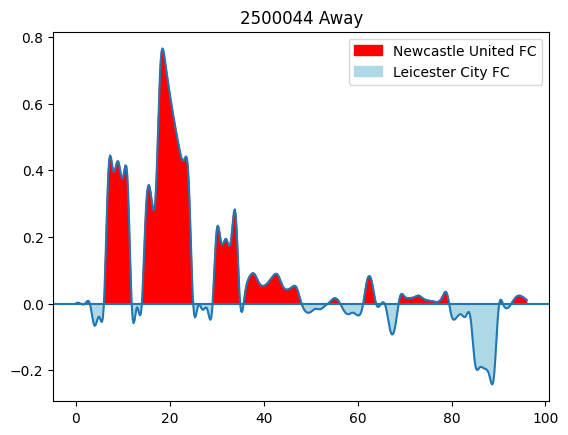

2500054


<ipython-input-7-683aa4242c8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_home_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  33


<ipython-input-7-683aa4242c8a>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# iterations:  33


<ipython-input-7-683aa4242c8a>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

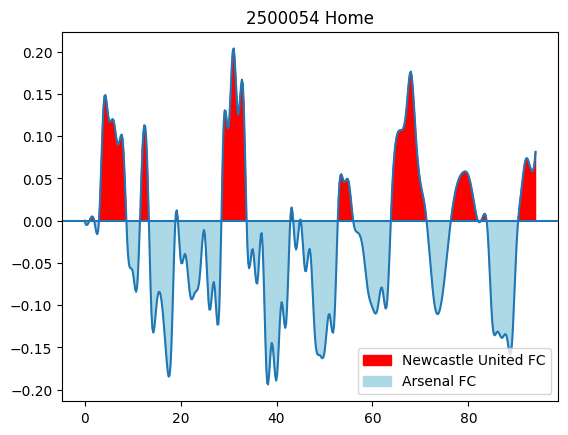

match id: 2500054
2500063
----------------------------------ELSE
-------------------------------------TRY:AWAY


<ipython-input-7-683aa4242c8a>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  succesful_away_events.drop(columns=['tag_200', 'tag_300', 'tag_400', 'tag_500', 'tag_600', 'tag_700',


# iterations:  23
------------------------------------------------TRY:HOME


<ipython-input-7-683aa4242c8a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['x1_bin']=pd.cut(df_xT_away['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_away['y1_bin']=pd.cut(df_xT_away['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# iterations:  23


<ipython-input-7-683aa4242c8a>:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['x1_bin']=pd.cut(df_xT_home['position1_x'], bins=grid_cols, labels=False)
<ipython-input-7-683aa4242c8a>:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xT_home['y1_bin']=pd.cut(df_xT_home['position1_y'], bins=grid_rows, labels=False)
<ipython-input-7-683aa4242c8a>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

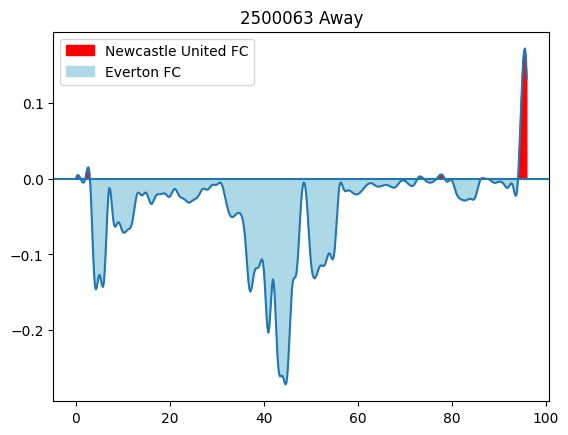

In [ ]:
df=match_momentum(1613)

# Threat Map

In [ ]:
# Choose team
team=1613

In [ ]:
# If csv doesn't exist, it needs to be created first with the notebook Data creation
matches=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/matches_{team}.csv').values

In [ ]:
matches=matches[:,1:].flatten()

# iterations:  34


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


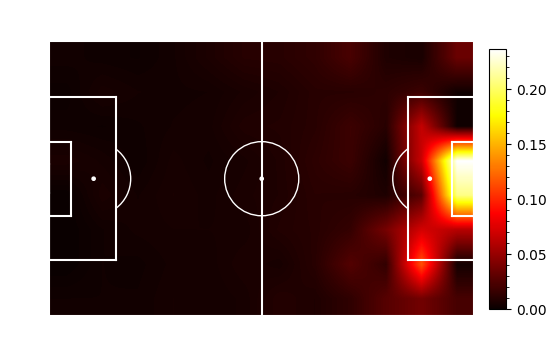

2500094
# iterations:  27


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


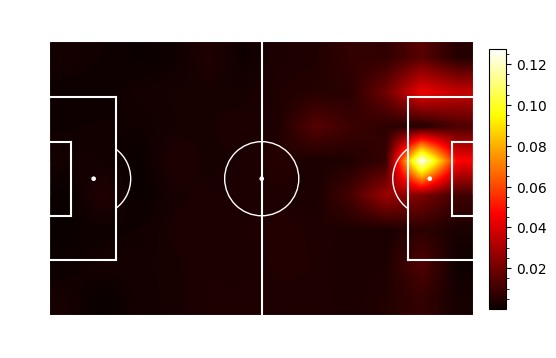

2500027
# iterations:  32


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


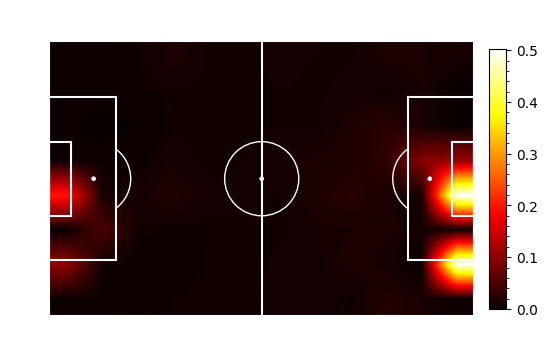

2500087
# iterations:  22


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


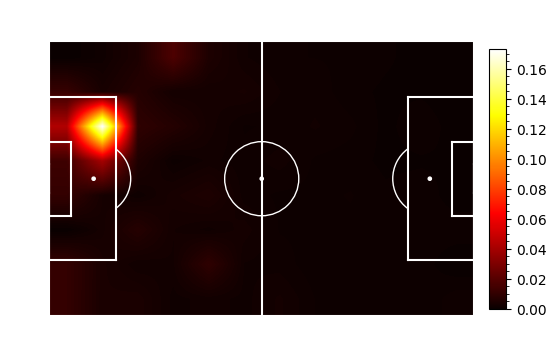

2500074
# iterations:  23


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


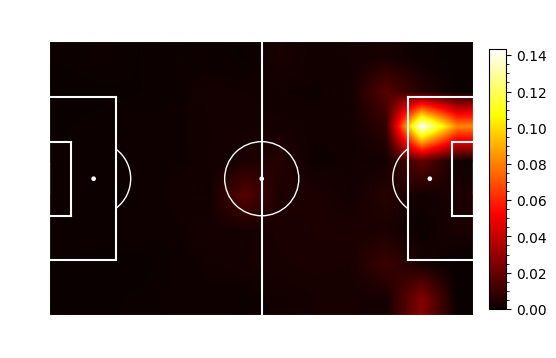

2500063
# iterations:  33


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


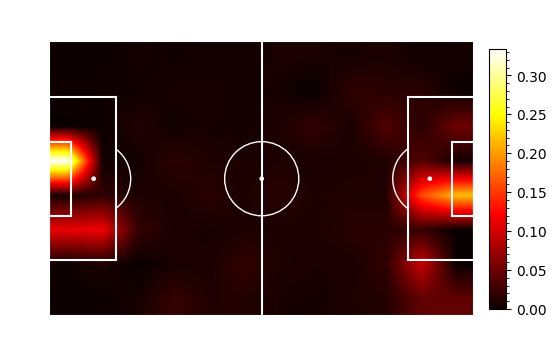

2500054
# iterations:  28


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


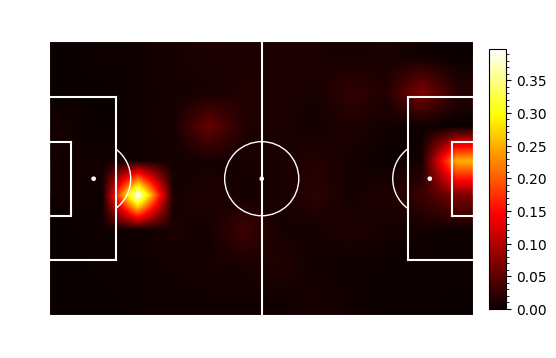

2500044
# iterations:  27


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


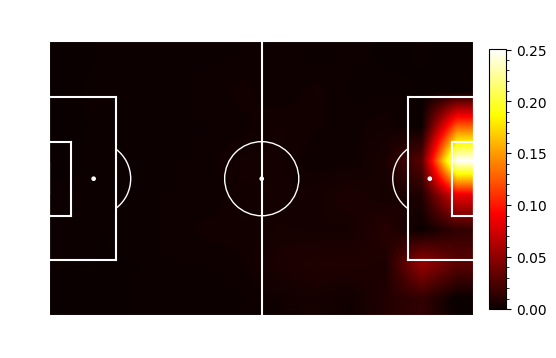

2500035
# iterations:  25


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


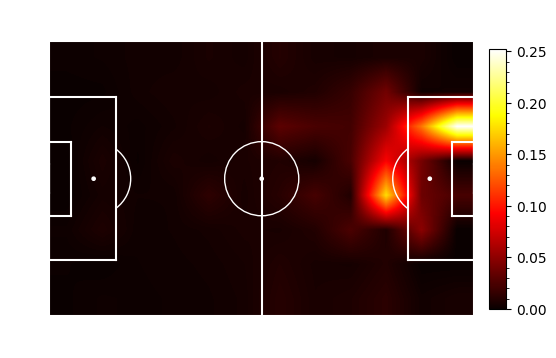

2500015
# iterations:  32


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


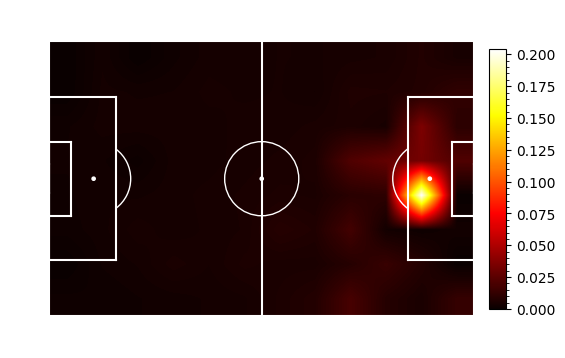

2500003
# iterations:  31


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


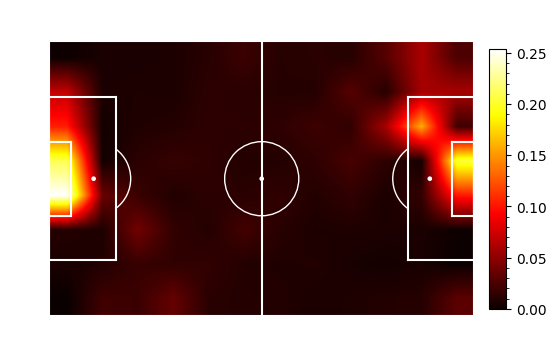

2499989
# iterations:  22


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


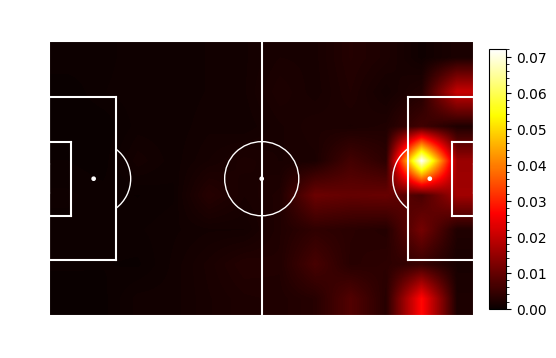

2499983
# iterations:  21


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


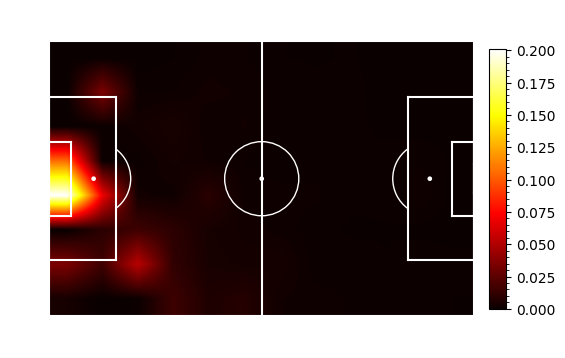

2499973
# iterations:  18


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


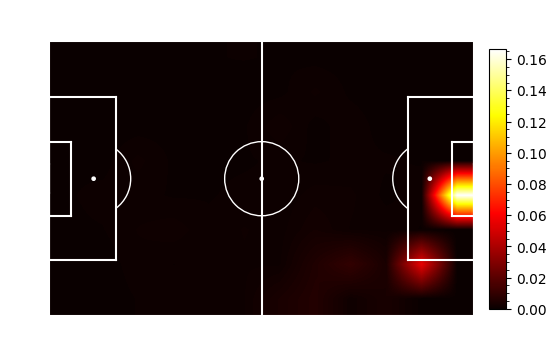

2499964
# iterations:  37


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


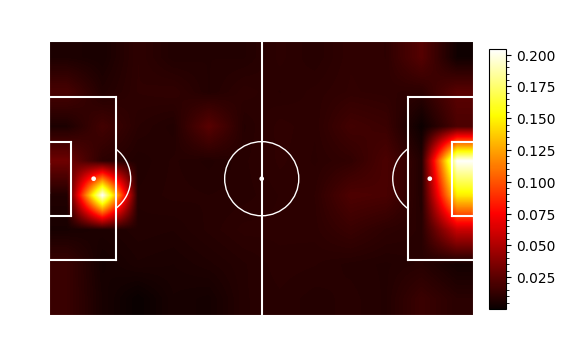

2499954
# iterations:  30


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


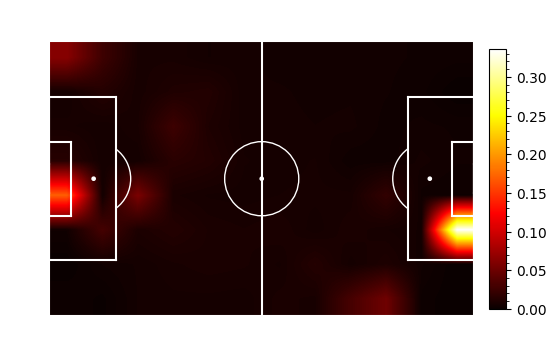

2499945
# iterations:  20


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


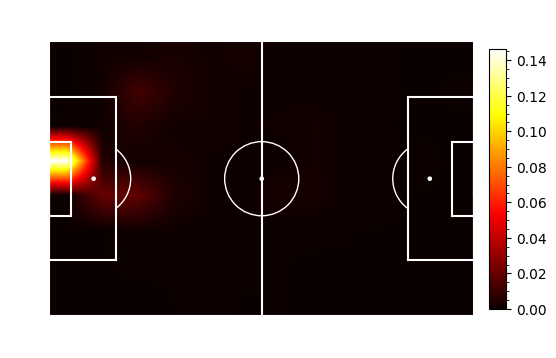

2499936
# iterations:  1
# iterations:  35


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


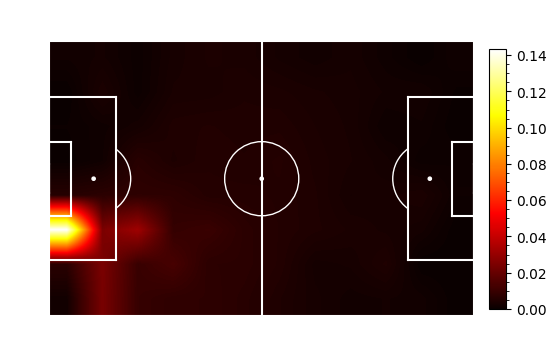

2499915
# iterations:  24


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


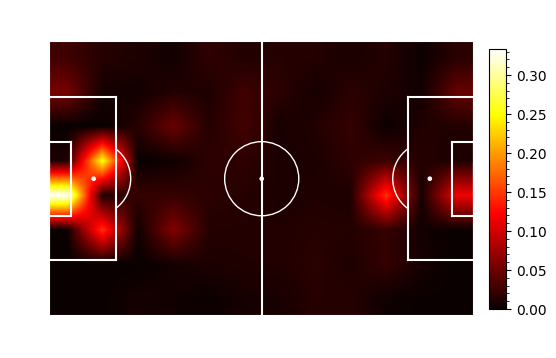

2499908
# iterations:  30


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


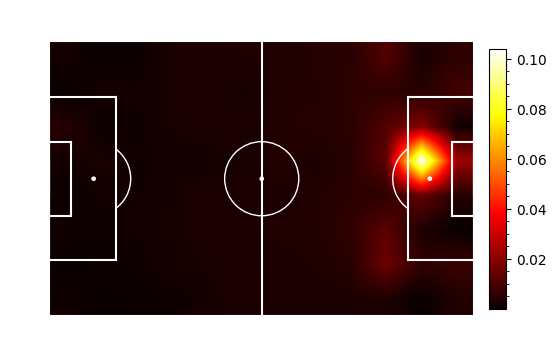

2499890
# iterations:  21


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


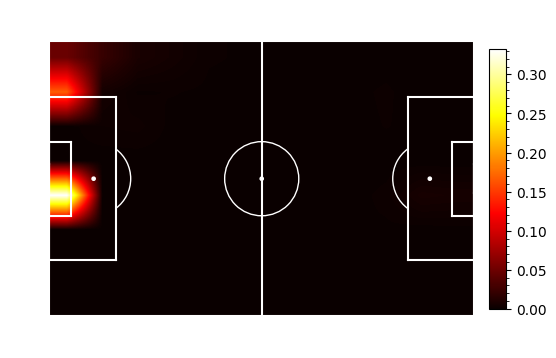

2499885
# iterations:  32


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


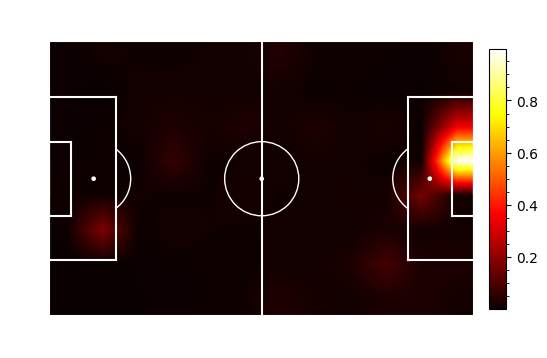

2499874
# iterations:  35


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


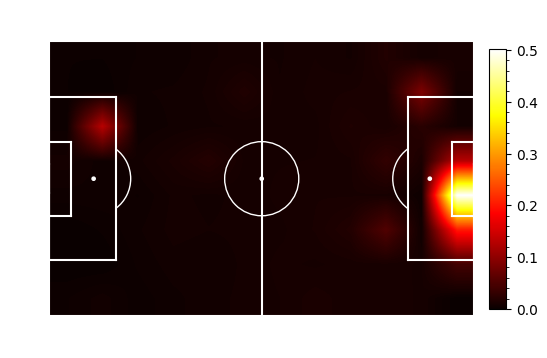

2499862
# iterations:  31


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


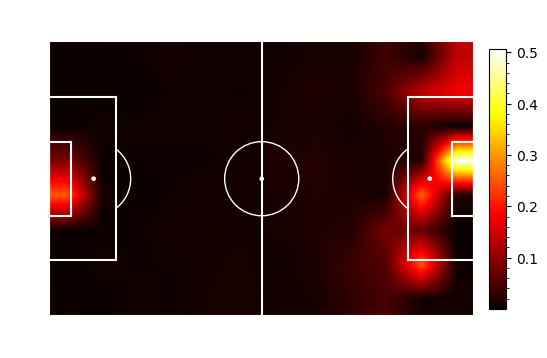

2499854
# iterations:  25


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


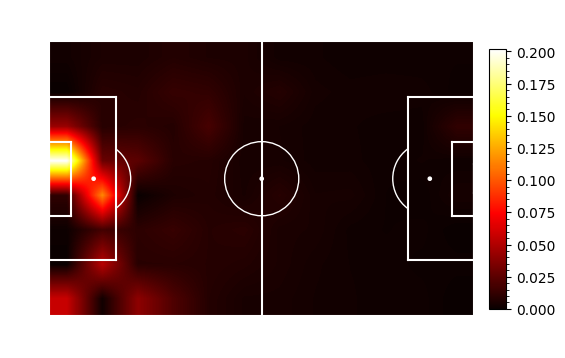

2499844
# iterations:  37


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


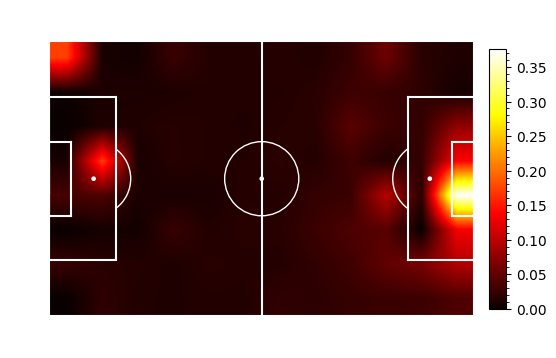

2499836
# iterations:  22


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


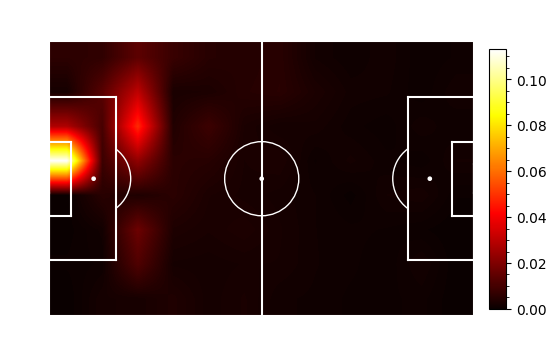

2499823
# iterations:  25


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


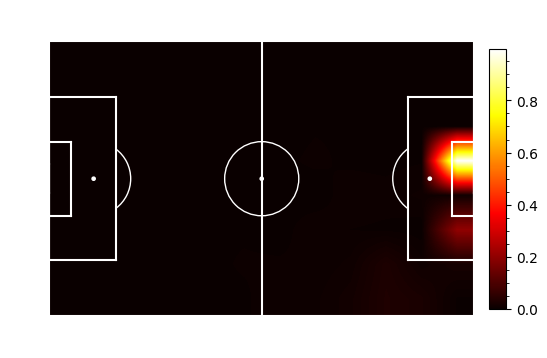

2499812
# iterations:  22


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


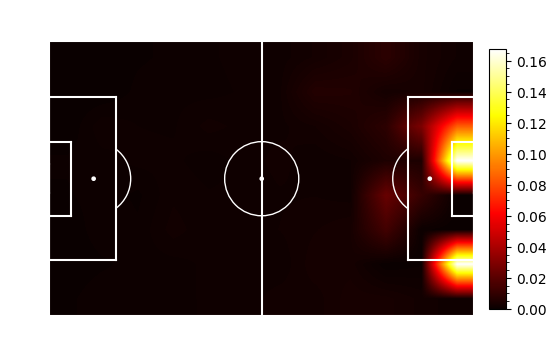

2499803
# iterations:  33


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


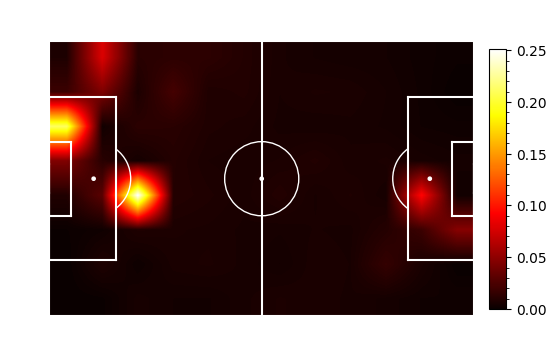

2499795
# iterations:  29


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


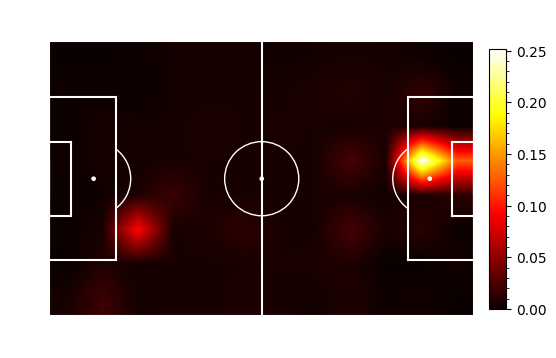

2499785
# iterations:  24


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


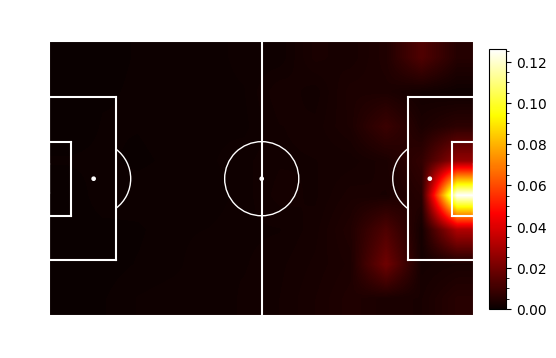

2499770
# iterations:  22


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


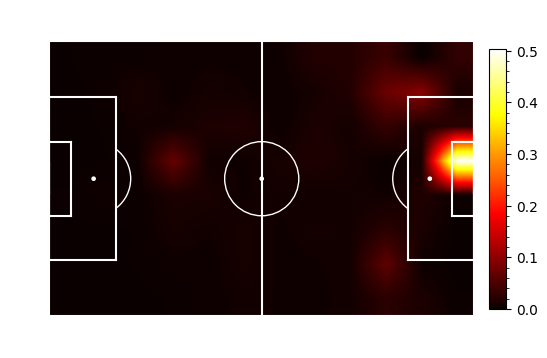

2499765
# iterations:  16


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


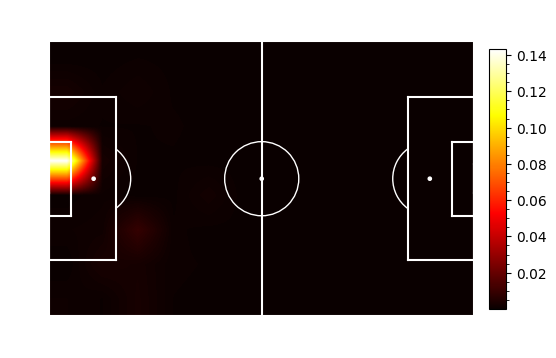

2499757
# iterations:  26


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


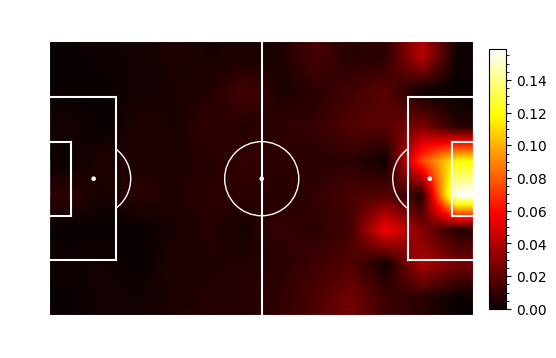

2499745
# iterations:  21


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


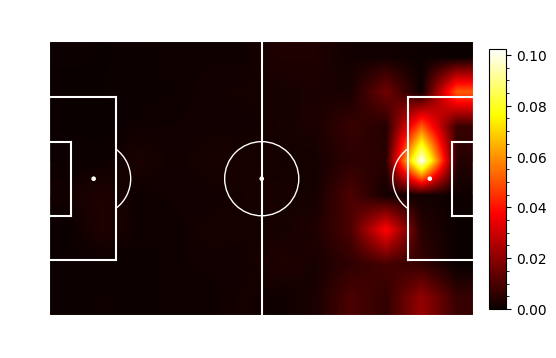

2499731
# iterations:  32


<ipython-input-19-ce9ba3df6391>:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")


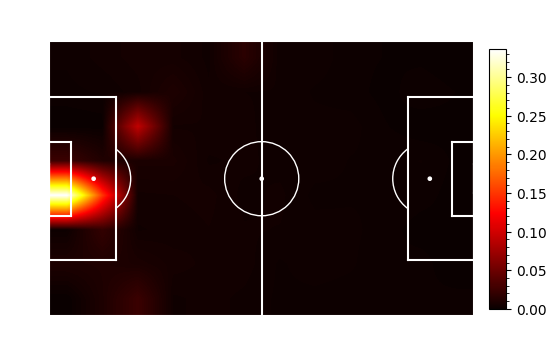

2499725
Black_list:[2499925]


In [ ]:
black_list=[]
df=pd.DataFrame(0,index=range(8),columns=range(12))
for game_id in matches:
  try:
    xTModel = xthreat.ExpectedThreat(l=12, w=8)
    df_actions_team=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/files/project/actions_{game_id}.csv')
    xTModel.fit(df_actions_team)
    xTModel.save_model(f'{team}_{game_id}.json',overwrite=True)
    df_grid=pd.read_json(f'{team}_{game_id}.json')
    df=df.add(df_grid)
    interp = xTModel.interpolator()
    x = np.linspace(0, 105, 1050)
    y = np.linspace(0, 68, 680)
    mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")
    print(game_id)
  except :
    black_list.append(game_id)
    pass
print('Black_list:'+f'{black_list}')